# 3.1 Analysis

In [1]:
import pandas as pd 
import glob
import re
import sys
import concurrent.futures
from Analysis import Analysis
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)

### Calculate the result for each bug

In [2]:
root = "/home/jovyan/work"
analyzer = Analysis(root)

projects = [ 
    "Cli", "Closure", "Time", "JacksonXml", "Collections", "Codec", "JxPath",
    "Compress", "Csv", "JacksonCore", "JacksonDatabind", 
    "Jsoup", "Lang", "Math", "Gson", "Mockito"
]
future_results = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    for project in projects:
        # FOR EACH BUG
        for bug_path in glob.glob("{root}/results/{project}/Bug_*/".format(root=root, project=project)):
            bug = re.search(r"Bug_(\d+)", bug_path).group(1)
            try:
                future = executor.submit(analyzer.analyzeBug, project, bug, False)
                future_results.append(future)
            except Exception as e:
                print(bug_path)
                print(e)

In [3]:
bug_results = []
for future in future_results:
    r = future.result() 
    bug_results.append(r)

### Example of bug result

In [4]:
bug_results[0]

{'id': 'Cli_Bug_28',
 'bug': 'Bug_28',
 'project': 'Cli',
 'fix_pass': True,
 'prev_fails': True,
 'category': 'No regression is detected',
 'sub_category': '-',
 'test_name': 'testPropertyOptionFlags',
 'bug_report': 'https://issues.apache.org/jira/browse/CLI-201',
 'fix_commit': '3433f467554985a6bd9bf530a4810376be6fe250',
 'BIC_candidates': [],
 'executionsOnPast': 302,
 'buildFail': 185,
 'buildTestFail': 128,
 'numCommits': 615,
 'totalDays': 2927,
 'transplantability_days': 1936,
 'transplantability_position': 447}

In [5]:
resume_df= pd.DataFrame(bug_results)[
    ['id', 'project','executionsOnPast', 'numCommits', 'totalDays',
     'buildFail', 'buildTestFail', 'BIC_candidates', 'transplantability_days', 'transplantability_position']
]

resume_df['one_bic_found'] = resume_df.apply (
    lambda row: 1 if len(row['BIC_candidates']) == 1 else 0, axis=1
)
resume_df['n_bic_found'] = resume_df.apply (
    lambda row: 1 if len(row['BIC_candidates']) > 1 else 0, axis=1
)
resume_df['executionsOnPast_rate'] = resume_df.apply (
    lambda row: row['executionsOnPast'] * 100 / row['numCommits'], axis=1
)
resume_df['compilability'] = resume_df.apply (
    lambda row: (row['numCommits']-row['buildFail']) * 100 / row['numCommits'], axis=1
)
resume_df['testCompilability'] = resume_df.apply (
    lambda row: (row['numCommits']-row['buildTestFail']-row['buildFail']) * 100 / row['numCommits'], axis=1
)

resume_df['transplantability_days_ratio'] = resume_df.apply (
    lambda row: (row['transplantability_days'] * 100) / row['totalDays'], axis=1
)
resume_df['transplantability_position_ratio'] = resume_df.apply (
    lambda row: (row['transplantability_position'] * 100) / row['numCommits'], axis=1
)

## RQ1A: “How far can a test be transplanted into the past”

In [6]:
resume_df.groupby('project').agg(
    bugs=('project','size'), 
    transplantability_days_mean=('transplantability_days','mean'),
    transplantability_days_median=('transplantability_days','median'),
    transplantability_days_percentage=('transplantability_days_ratio','mean'),
    transplantability_position_mean=('transplantability_position','mean'),
    transplantability_position_median=('transplantability_position','median'),
    transplantability_position_percentage=('transplantability_position_ratio','mean')
).round(2)#.astype(int)

,bugs,transplantability_days_mean,transplantability_days_median,transplantability_days_percentage,transplantability_position_mean,transplantability_position_median,transplantability_position_percentage
project,,,,,,,
Cli,39,913.79,1168.0,34.87,134.77,115.0,33.44
Closure,174,235.27,108.5,36.74,453.09,192.0,39.79
Codec,18,703.50,427.0,22.17,195.17,83.0,21.58
Collections,4,599.00,703.0,11.05,178.75,213.5,6.30
Compress,47,1914.13,2051.0,47.88,1242.40,1331.0,83.24
Csv,16,106.81,41.5,3.11,41.38,27.5,5.17
Gson,18,1283.67,1212.5,47.60,481.33,368.0,41.70
JacksonCore,26,444.81,450.5,32.98,262.58,258.5,34.00
JacksonDatabind,112,726.10,691.5,44.50,1200.34,1181.0,41.41


In [7]:
t_days = resume_df['transplantability_days']
t_position = resume_df['transplantability_position']
t_days_ratio = resume_df['transplantability_days_ratio']
t_position_ratio = resume_df['transplantability_position_ratio']
print("Transplantability in days (Mean/Median/Ratio): %d %d %.2f"%(t_days.mean(), t_days.median(), t_days_ratio.mean()))
print("Transplantability in # commits (Mean/Median/Ratio): %d %d %.2f"%(t_position.mean(), t_position.median(), t_position_ratio.mean()))

Transplantability in days (Mean/Median/Ratio): 591 313 32.58
Transplantability in # commits (Mean/Median/Ratio): 536 216 33.54


,count,mean,std,min,25%,50%,75%,max
transplantability_days,809,591,708,0,87,313,832,3475
transplantability_position,809,536,699,1,76,216,727,3709


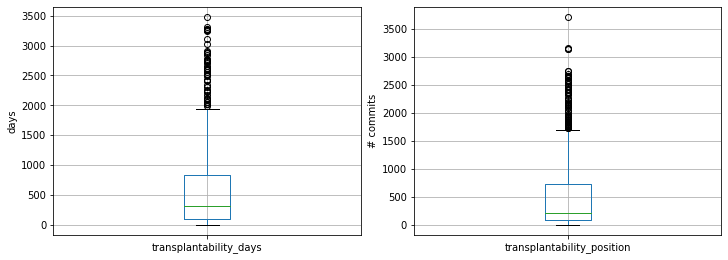

In [8]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 3.5), layout="constrained")

resume_df.boxplot(column='transplantability_days', ax=axs[0])
axs[0].set_ylabel("days")

resume_df.boxplot(column='transplantability_position', ax=axs[1])
axs[1].set_ylabel("# commits")

resume_df[['transplantability_days', 'transplantability_position']].describe().astype(int).T

In [9]:
for bug in bug_results:
    if bug['transplantability_position'] < 1:
        print(bug)

In [10]:
regressions_df = pd.DataFrame(bug_results)[
    ['id', 'project','category', 'sub_category', 'bic_position', 'bic_age']
]
regressions_df = regressions_df[regressions_df['sub_category']=='Unique candidates']
bic_position = regressions_df['bic_position']
bic_age = regressions_df['bic_age']
print("BIC position (Mean/Median): %d %d"%(bic_position.mean(), bic_position.median()))
print("BIC age (Mean/Median): %d %d"%(bic_age.mean(), bic_age.median()))

BIC position (Mean/Median): 351 101
BIC age (Mean/Median): 266 109


## RQ1B: “How compilability and runnability problems impact the transplantation of the regression tests to the past?”

In [11]:
resume_df_agg = resume_df.groupby('project').agg(
    bugs=('project','size'), 
    #s_bics=('one_bic_found','sum'),
    #m_bics=('n_bic_found','sum'),
    compilability_mean=('compilability','mean'), 
    compilability_median=('compilability','median'),
    test_compilability_mean=('testCompilability','mean'), 
    test_compilability_median=('testCompilability','median'),
    ratio_mean=('executionsOnPast_rate','mean'), 
    ratio_median=('executionsOnPast_rate','median'),
)
compilability = resume_df['compilability']
t_compilability = resume_df['testCompilability']
t_runnability = resume_df['executionsOnPast_rate']
print("Src Compilability (Mean/Median): %.2f %.2f"%(compilability.mean(), compilability.median()))
print("Test Compilability (Mean/Median): %.2f %.2f"%(t_compilability.mean(), t_compilability.median()))
print("Test runability (Mean/Median): %.2f %.2f"%(t_runnability.mean(), t_runnability.median()))
resume_df_agg.round(2)

Src Compilability (Mean/Median): 52.95 49.83
Test Compilability (Mean/Median): 21.86 12.75
Test runability (Mean/Median): 21.74 12.47


,bugs,compilability_mean,compilability_median,test_compilability_mean,test_compilability_median,ratio_mean,ratio_median
project,,,,,,,
Cli,39,55.66,62.61,28.19,30.88,28.19,30.88
Closure,174,59.40,54.36,34.47,17.82,34.47,17.82
Codec,18,23.74,14.29,20.44,8.84,20.44,8.84
Collections,4,97.94,98.98,5.73,7.46,5.61,7.37
Compress,47,32.29,23.60,22.90,17.02,21.07,10.92
Csv,16,19.07,17.38,5.26,3.51,5.21,3.51
Gson,18,42.00,35.98,40.73,34.68,40.73,34.68
JacksonCore,26,35.08,32.54,31.52,30.12,31.52,30.12
JacksonDatabind,112,85.18,85.59,21.97,16.02,21.97,16.02


In [12]:
resume_df[['compilability','testCompilability','executionsOnPast_rate']].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
compilability,809.0,52.95,31.87,1.58,24.88,49.83,82.5,100.00
testCompilability,809.0,21.86,24.37,0.10,4.36,12.75,30.5,99.66
executionsOnPast_rate,809.0,21.74,24.39,0.10,4.36,12.47,30.4,99.66


## RQ2: “Can the BIC for a given bug be found using its regression test?”

### Summary of results

In [13]:
df = pd.DataFrame(bug_results)[['id', 'project','category', 'sub_category']]
df[df['category'] != None].set_index('id').sort_index()
print(len(df))
df.groupby(['category', "sub_category"]).count()['id']

809


category                   sub_category       
A regression is detected   Multiple candidates      4
                           Unique candidates       95
No regression is detected  -                      710
Name: id, dtype: int64

In [16]:
for result in bug_results:
    if result['sub_category'] == "Multiple candidates":
        print(result['project'], result['bug'], len(result['BIC_candidates']))

JacksonDatabind Bug_14 2
Math Bug_28 2
Gson Bug_7 2
Mockito Bug_20 17


## Analysis of BICs with multiple candidates
- **JacksonDatabind 14 (2 candidates)**: Of the two candidates, the first one (chronologically) only adds a test that does not compile (it is missing a static variable created in the next commit). The second one does add new functionality to the source code (the ObjectReader class is modified) which introduces the bug (making the test stop passing) and the BFC fixes that same class.

- **Math 28 (2 candidates)**: Commit 5 includes changes to a feature, using the FastMath class from the odk package. In commit 4 the import of the package is corrected, importing this class locally. Commit 5 (not buildable) is actually the BIC.

- **Gson 7 (2 candidates)**: For this bug there are 2 candidates to be the BIC. In commit 335 the entire Json Reader class is deleted, which prevents the code from compiling. In commit 334 the JsonReader2 class is renamed to JsonReader, replacing the previous one. It is this second change that actually introduces the bug (by replacing the previous class).

- **Mockito 20 (17 candidates)**: In the commit following the first commit that passes again begins a re-implementation of PluginLoader used by the Mockito library, changing from CglibMockMaker to ByteBuddyMockMaker. The development lasts 16 commits, during which the project cannot compile, as classes are required to be added in later commits. After finalizing the functionality, the test starts to fail until the BFC.